In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
from uuid import uuid4

import pandas as pd
import numpy as np
import torchaudio
from speechbrain.pretrained import EncoderClassifier
from tqdm.auto import tqdm
import torch

sys.path.append("..")
from sgs_utils.path_conf import loc_data_dir, speech_data_session_dir, interim_seech_data_dir
from sgs_utils.data_filtering import get_valid_mask

import seaborn as sns
import plotly.express as px

sns.set_context("talk")


from sklearn.manifold import TSNE

In [5]:
df_session = pd.read_parquet(loc_data_dir.joinpath("df_session_tot_cleaned.parquet"))

#  `ECAPA-TDNN` embeddings (*Full duration*)

In [8]:
extracted_embeddings = False


In [9]:
if not extracted_embeddings:
    # These are temporary uuid's to use a primary key for linkage with the 
    # ECAPA TDNN embeddings
    df_session["uuid"] = [str(uuid4()) for _ in range(len(df_session))]

    # load the ECAPA-TDNN classifier
    classifier = EncoderClassifier.from_hparams(
        source="speechbrain/spkrec-ecapa-voxceleb"
    )

    if torch.cuda.is_available():
        print(torch.cuda.get_device_name())
        classifier = classifier.cuda()
        classifier.device = f"cuda:{torch.cuda.current_device()}"
        print(classifier.device)

    uuid_embedding = {}

    for _, row in tqdm(list(df_session.iterrows())):
        signal, fs = torchaudio.load(
            list(
                list(speech_data_session_dir.glob(f"*{row.ID}*"))[0]
                .joinpath(row.DB)
                .glob(f"*{row.time_str}*.wav")
            )[0],
            channels_first=False,
        )
        if signal.size()[0] == 0:
            continue
        # Note: `classifier.audio_normalize` withholds the logic to normalize the audio to the
        # desired format of the ECAPA-TDNN architecture
        uuid_embedding[row.uuid] = (
            classifier.encode_batch(classifier.audio_normalizer(signal, fs))
            .cpu()
            .numpy()
            .ravel()
        )
        
        break

    df_emb = pd.DataFrame(uuid_embedding).T.add_prefix("emb_")
    df_emb.index.name = "uuid"
    df_emb.index = df_emb.index.astype("str")
    df_emb = df_emb.reset_index(drop=False)
    df_emb = df_emb.merge(df_session, on="uuid", how="left")
    df_emb = df_emb[["ID", "DB", "time_str"] + list(df_emb.filter(like="emb_").columns)]

    df_session.drop(columns='uuid', inplace=True)

    del row, signal, fs, uuid_embedding

    # df_emb.to_parquet(loc_data_dir.joinpath("ECAPA_TDNN_emb.parquet"))

else:
    df_emb = pd.read_parquet(loc_data_dir.joinpath("ECAPA_TDNN_emb.parquet"))


NVIDIA GeForce RTX 2070


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

## Merge the embeddings with the session data

In [74]:
df_emb_tot = pd.merge(df_session, df_emb.reset_index(), on=["ID", "DB", "time_str"])
df_emb_tot["speech_style"] = df_emb_tot.DB.map(
    lambda x: {"marloes": "Read", "PiSCES": "SGS", "Radboud": "SGS"}.get(x)
)

df_emb_tot.filter(like="emb_").head(n=3)


emb_0      emb_1      emb_2      emb_3      emb_4      emb_5  \
0  10.845679   5.382305   7.451254  34.372238   8.796760 -31.821655   
1  19.874956  16.556976  10.529055  41.641254   7.524238 -32.456047   
2  23.808506  16.951443   8.955536  26.896732  17.231157 -39.343960   

       emb_6      emb_7      emb_8      emb_9  ...    emb_182    emb_183  \
0  40.454338  32.812218 -17.802948   2.967707  ... -16.892115  -0.153739   
1  49.526112  45.022415  -7.953416 -24.295065  ... -21.908144  12.855311   
2  60.201000  30.035782  -8.756324 -34.991348  ... -18.477686  14.733150   

     emb_184   emb_185    emb_186    emb_187    emb_188    emb_189   emb_190  \
0   3.086036  2.643244 -28.136105 -13.728223  22.046213 -27.881063 -1.576936   
1   0.265465 -5.374442 -25.505505  -9.872204  30.987688 -18.339260  0.307239   
2 -12.037816 -2.128363 -18.772427  -7.792617  19.614975 -15.398038  2.876788   

     emb_191  
0 -11.779755  
1 -10.400024  
2 -17.378206  

[3 rows x 192 columns]

In [75]:
valid_mask = (df_emb_tot["wav_duration_s"] > 16.5) & get_valid_mask(df_emb_tot)
print(f"{sum(valid_mask)} / {len(valid_mask)}")
df_emb_tot_v = df_emb_tot[valid_mask].reset_index(drop=True)
del df_emb_tot

3024 / 3199


# Embedding Data analysis - `TSNE`

use the `TSNE` decomposition for analysing the lower dimensional representations of the embeddings.

In [77]:
# We want to get TSNE embeddings with 2 dimensions
n_components = 2
tsne = TSNE(
    n_components, perplexity=100, learning_rate="auto", init="pca"
)  # perplexity = # allowed nearest neighbours
tsne_result = tsne.fit_transform(df_emb_tot_v.filter(like="emb_"))


def construct_tsne_df(tnse_result: np.ndarray) -> pd.DataFrame:
    tsne_result_df = pd.DataFrame(tnse_result).add_prefix("tsne_")
    for c in [
        "pic_name",
        "timestamp",
        "wav_timestamp",
        "wav_duration_s",
        "ID",
        "DB",
        "sex",
        "age",
        "speech_style",
    ]:
        tsne_result_df[c] = df_emb_tot_v[c]
    return tsne_result_df


/home/jonas/.cache/pypoetry/virtualenvs/semi-guided-speech-27YL4uf1-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



## Visualize TSNE

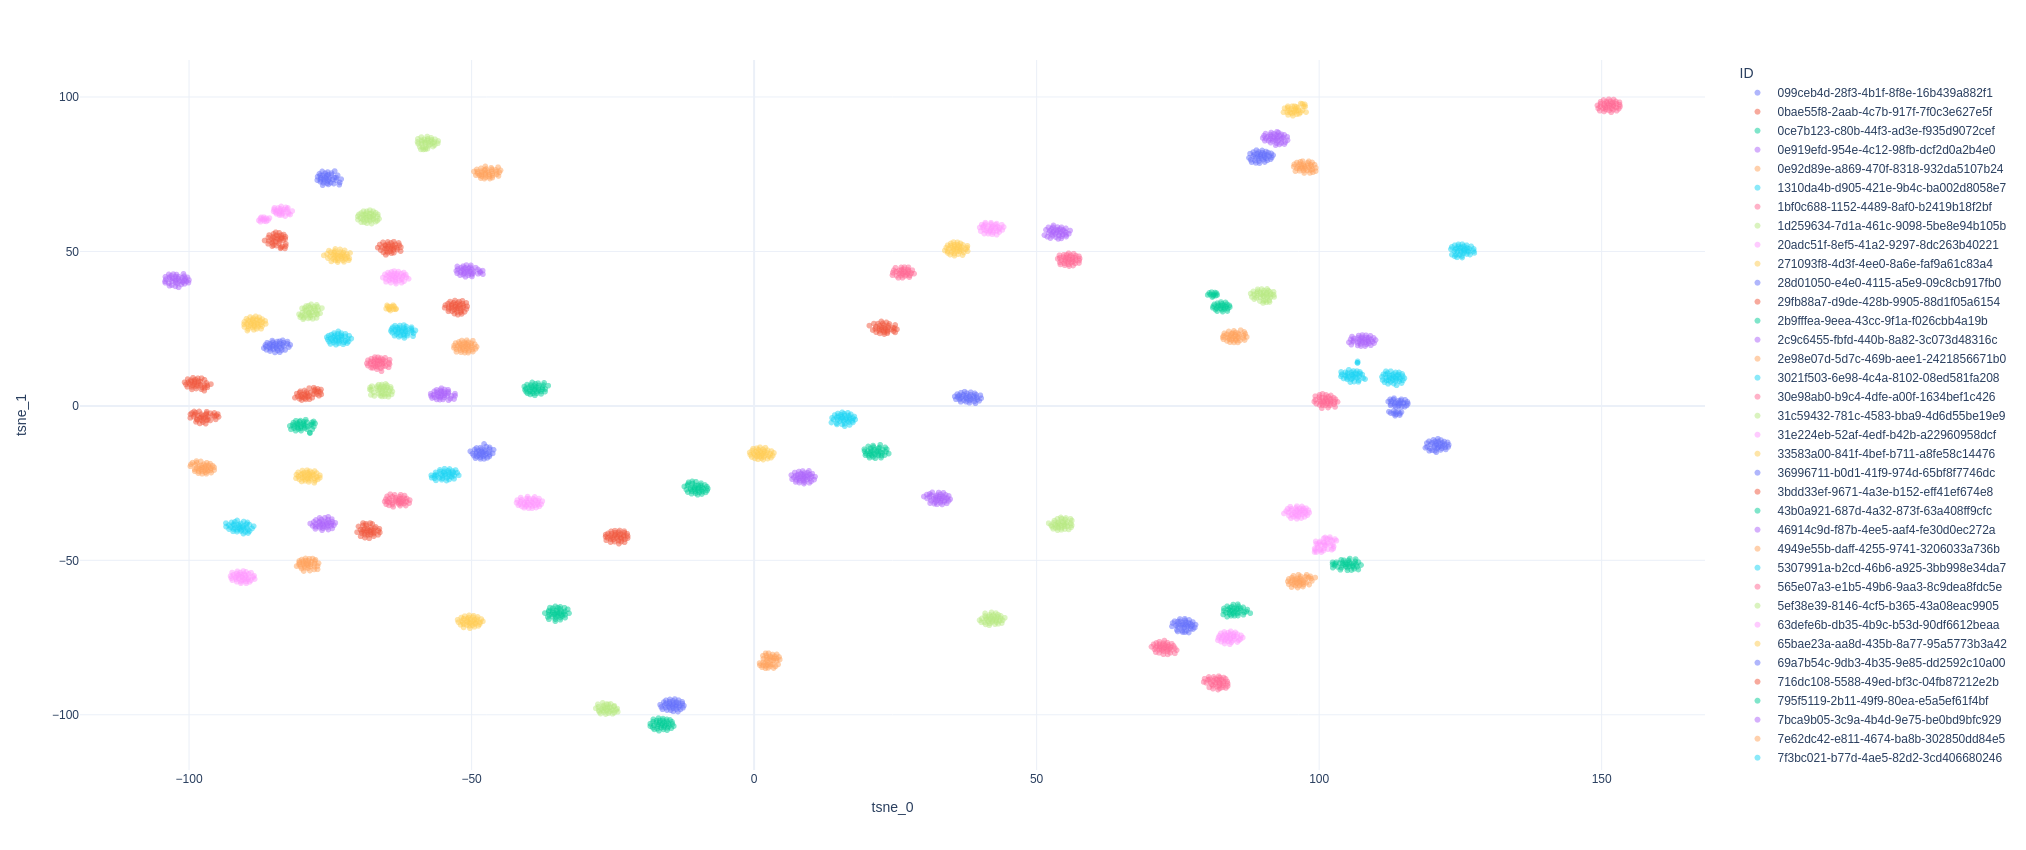

In [78]:
px.scatter(
    construct_tsne_df(tsne_result),
    x="tsne_0",
    y="tsne_1",
    color="ID",
    hover_data=["timestamp", "pic_name", "wav_timestamp"],
    opacity=0.5,
    height=850,
    template="plotly_white",
)


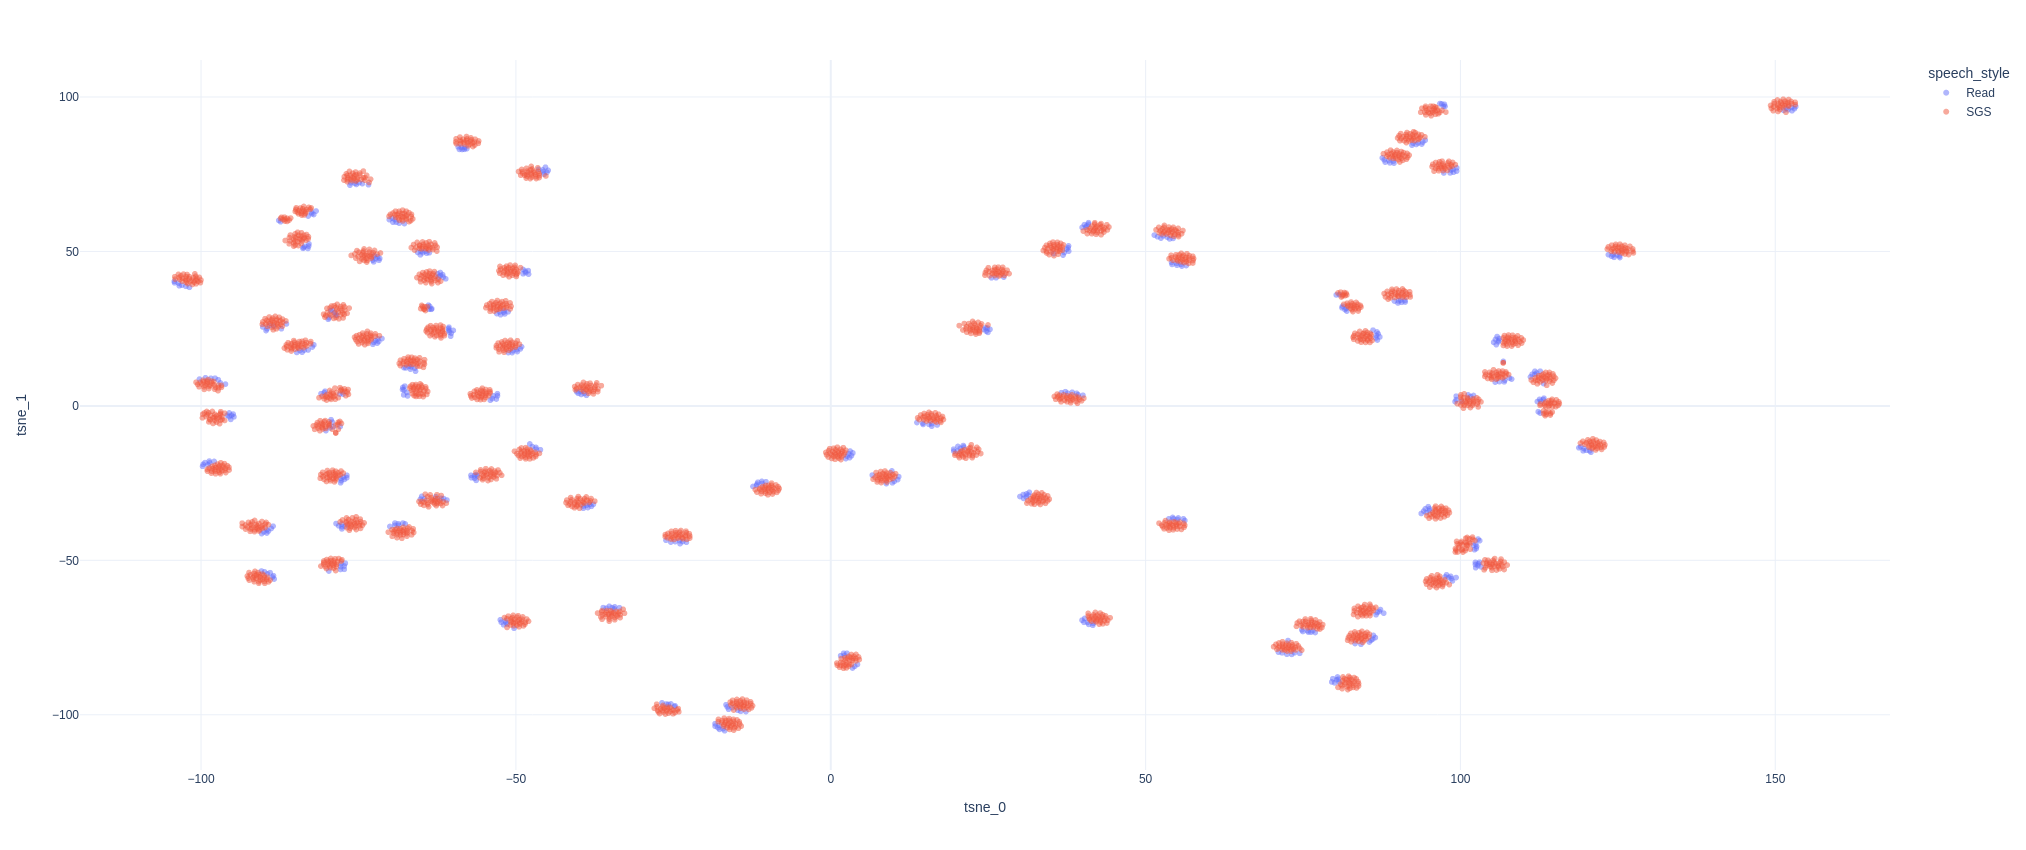

In [81]:
px.scatter(
    construct_tsne_df(tsne_result),
    x="tsne_0",
    y="tsne_1",
    color="speech_style",
    hover_data=["ID", "timestamp", "pic_name", "wav_timestamp"],
    opacity=0.5,
    height=850,
    template="plotly_white",
)


In [19]:
# df_session[
#     (df_session["ID"] == "5307991a-b2cd-46b6-a925-3bb998e34da7")
#     & (df_session["pic_name"] == "Picture 110")
# ]


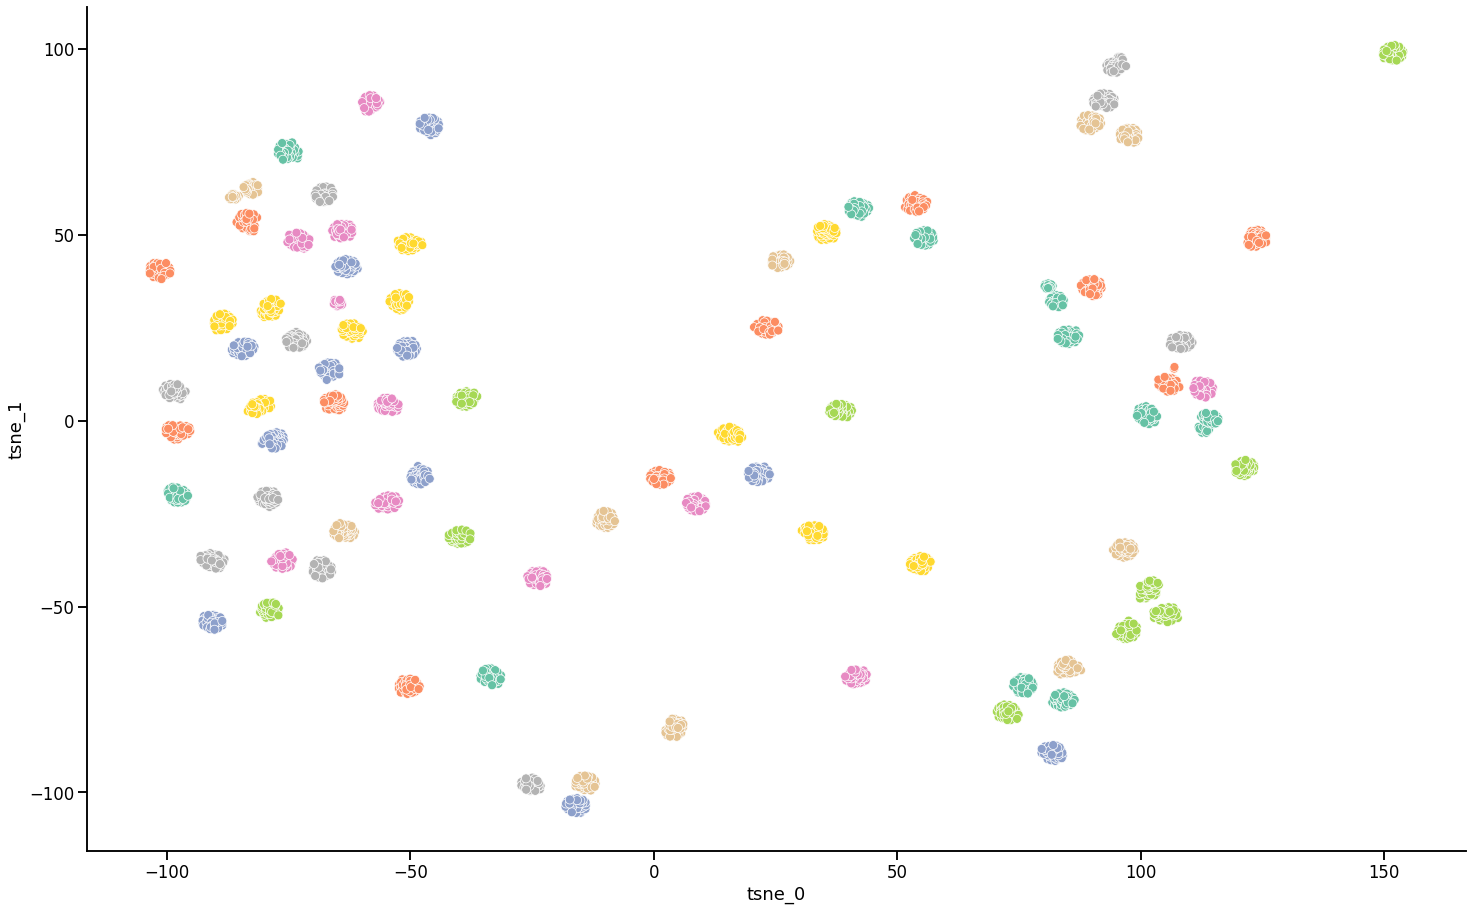

In [20]:
sns.relplot(
    data=construct_tsne_df(tsne_result),
    x="tsne_0",
    y="tsne_1",
    hue="ID",
    height=13,
    kind="scatter",
    palette="Set2",
    aspect=1.6,
    legend=False,
)


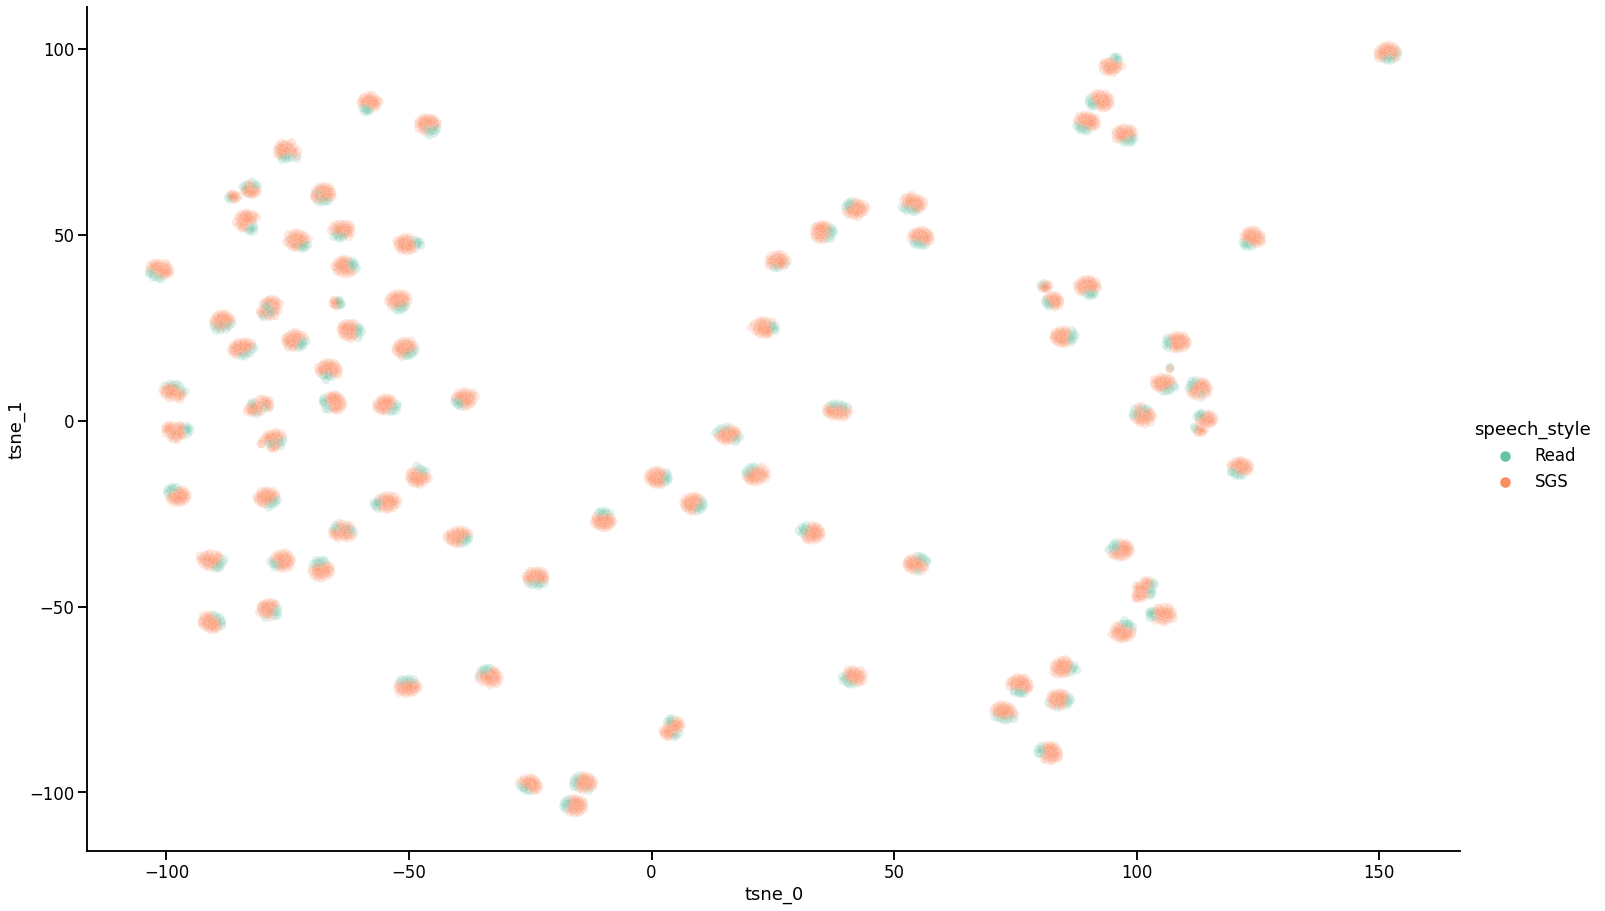

In [21]:
sns.relplot(
    data=construct_tsne_df(tsne_result),
    x="tsne_0",
    y="tsne_1",
    hue="speech_style",
    height=13,
    kind="scatter",
    palette="Set2",
    aspect=1.6,
    alpha=0.2,
)


# Machine learning: testing `speech-style` seperability 

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    average_precision_score,
    f1_score,
    roc_auc_score,
    classification_report,
)
from sklearn.model_selection import (
    StratifiedGroupKFold,
    cross_val_score,
    cross_validate,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer
import matplotlib.pyplot as plt


In [23]:
df_emb_tot_v["speech_style"].values


array(['Read', 'SGS', 'SGS', ..., 'SGS', 'SGS', 'Read'], dtype=object)

In [25]:
model = Pipeline(
    [
        ("scaling", PowerTransformer()),
        ("lr", LogisticRegression(C=0.1, max_iter=200, solver="liblinear")),
    ]
)

cvs = cross_val_score(
    estimator=model,
    X=df_emb_tot_v.filter(like="emb_"),
    y=df_emb_tot_v["speech_style"],
    scoring="balanced_accuracy",
    cv=StratifiedGroupKFold(n_splits=5),
    groups=df_emb_tot_v["ID"],
)
print(cvs.round(3))
print(f"{cvs.mean().round(3)}±{cvs.std().round(3)}")


[0.771 0.847 0.859 0.758 0.815]
0.81±0.04


In [26]:
X = df_emb_tot_v.filter(like="emb_").values
y = df_emb_tot_v["speech_style"].values
groups = df_emb_tot_v["ID"]


              precision    recall  f1-score   support

        Read       0.54      0.67      0.60       112
         SGS       0.92      0.87      0.90       500

    accuracy                           0.83       612
   macro avg       0.73      0.77      0.75       612
weighted avg       0.85      0.83      0.84       612



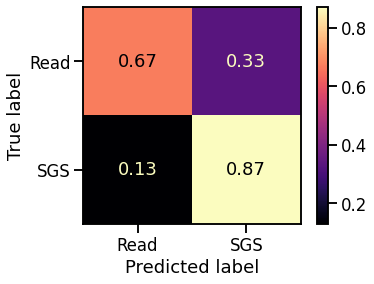

              precision    recall  f1-score   support

        Read       0.56      0.84      0.67       112
         SGS       0.96      0.85      0.90       500

    accuracy                           0.85       612
   macro avg       0.76      0.85      0.79       612
weighted avg       0.89      0.85      0.86       612



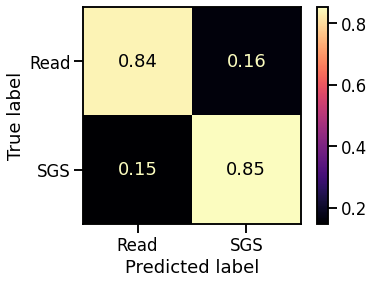

              precision    recall  f1-score   support

        Read       0.68      0.81      0.74       114
         SGS       0.95      0.91      0.93       483

    accuracy                           0.89       597
   macro avg       0.82      0.86      0.84       597
weighted avg       0.90      0.89      0.89       597



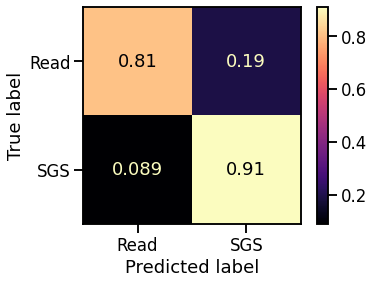

              precision    recall  f1-score   support

        Read       0.46      0.71      0.56       116
         SGS       0.92      0.81      0.86       500

    accuracy                           0.79       616
   macro avg       0.69      0.76      0.71       616
weighted avg       0.84      0.79      0.81       616



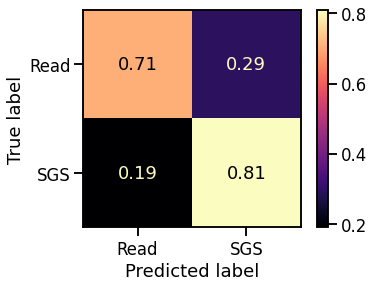

              precision    recall  f1-score   support

        Read       0.52      0.80      0.63       111
         SGS       0.95      0.83      0.88       476

    accuracy                           0.82       587
   macro avg       0.73      0.81      0.76       587
weighted avg       0.87      0.82      0.84       587



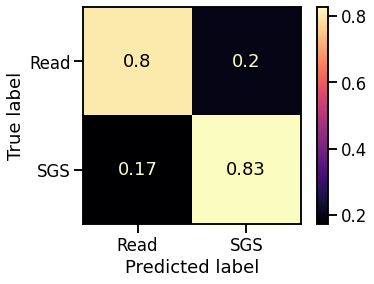

In [27]:
mf1s = []
aps = []
aucs = []
kf = StratifiedGroupKFold(n_splits=5)
for train_idx, test_idx in kf.split(X, y=y, groups=groups):
    x_train_ = X[train_idx, :]
    x_test_cv_ = X[test_idx, :]
    model = model.fit(x_train_, y[train_idx])
    preds = model.predict(x_test_cv_)
    preds_proba = model.predict_proba(x_test_cv_)[:, 1]
    mf1s += [f1_score(y[test_idx], preds, average="macro")]
    print(classification_report(y[test_idx], preds))
    ConfusionMatrixDisplay.from_estimator(model, x_test_cv_, y[test_idx], normalize="true", cmap='magma')
    plt.show()
    # aps += [average_precision_score(y[test_idx], preds_proba)]
    # aucs += [roc_auc_score(y[test_idx], preds_proba)]


---

# Extract `ECAPA TDNN` embeddings - *Fixed duration*

In [28]:
DUR_S = 15
START_FROM_END = False
extracted_embeddings = False

In [29]:
if not extracted_embeddings:
    # load the ECAPA-TDNN classifier
    classifier = EncoderClassifier.from_hparams(
        source="speechbrain/spkrec-ecapa-voxceleb"
    )

    if torch.cuda.is_available():
        print(torch.cuda.get_device_name())
        classifier = classifier.cuda()
        classifier.device = f"cuda:{torch.cuda.current_device()}"
        print(classifier.device)

    # These are temporary uuid's to use a primary key for linkage with the
    # ECAPA TDNN embeddings
    df_session["uuid"] = [str(uuid4()) for _ in range(len(df_session))]

    uuid_embedding = {}
    for _, row in tqdm(list(df_session.iterrows())):
        signal, fs = torchaudio.load(
            list(
                list(speech_data_session_dir.glob(f"*{row.ID}*"))[0]
                .joinpath(row.DB)
                .glob(f"*{row.time_str}*.wav")
            )[0],
            channels_first=False,
        )

        preferred_offset_s = 5
        if row.wav_duration_s < (DUR_S + 1):
            continue

        # slice the signal to the correct duration
        # (we do not use the first 0.5 second and the last second)
        if START_FROM_END:
            # The problem is that we have few audio data at the end
            realistic_offset = max(
                1, min(preferred_offset_s, row.wav_duration_s - DUR_S)
            )
            # print(preferred_offset_s, row.wav_duration_s, realistic_offset)
            signal = signal[
                max(0, int((row.wav_duration_s - realistic_offset - DUR_S) * fs)) : int(
                    (row.wav_duration_s - realistic_offset) * fs
                )
            ]
        else:
            realistic_offset = max(
                1, min(preferred_offset_s, row.wav_duration_s - DUR_S)
            )
            # print(preferred_offset_s, row.wav_duration_s, realistic_offset)
            signal = signal[
                int(realistic_offset * fs) : int((realistic_offset + DUR_S) * fs)
            ]
            # print(signal.shape)

        # Note: `classifier.audio_normalize` withholds the logic to normalize the audio to the
        # desired format of the ECAPA-TDNN architecture
        uuid_embedding[row.uuid] = (
            classifier.encode_batch(classifier.audio_normalizer(signal, fs))
            .cpu()
            .numpy()
            .ravel()
        )

    df_emb_fixed_dur = pd.DataFrame(uuid_embedding).T.add_prefix("emb_")
    df_emb_fixed_dur.index.name = "uuid"
    df_emb_fixed_dur.index = df_emb_fixed_dur.index.astype("str")
    df_emb_fixed_dur = df_emb_fixed_dur.reset_index(drop=False)
    df_emb_fixed_dur = df_emb_fixed_dur.merge(df_session, on="uuid", how="left")
    df_emb_fixed_dur = df_emb_fixed_dur[
        ["ID", "DB", "time_str"] + list(df_emb_fixed_dur.filter(like="emb_").columns)
    ]

    # These are temporary uuid's to use a primary key for linkage with the
    # ECAPA TDNN embeddings
    df_session["uuid"] = [str(uuid4()) for _ in range(len(df_session))]

    del row, signal, fs, uuid_embedding
    df_emb_fixed_dur.to_parquet(
        loc_data_dir.joinpath(
            f"ECAPA_TDNN_emb_{DUR_S}s_{'end' if START_FROM_END else 'start'}.parquet"
        )
    )

else:
    df_emb_fixed_dur = pd.read_parquet(
        loc_data_dir.joinpath(
            f"ECAPA_TDNN_emb_{DUR_S}s_{'end' if START_FROM_END else 'start'}.parquet"
        )
    )


NVIDIA GeForce RTX 2070
cuda:0


100%|██████████| 3199/3199 [03:31<00:00, 15.12it/s]


In [30]:
df_emb_fixed_dur.head(2)

ID       DB  time_str      emb_0  \
0  099ceb4d-28f3-4b1f-8f8e-16b439a882f1  marloes  16:53:49   9.964561   
1  099ceb4d-28f3-4b1f-8f8e-16b439a882f1   PiSCES  16:54:45  10.075651   

       emb_1     emb_2      emb_3      emb_4      emb_5      emb_6  ...  \
0   7.785605  9.135481  30.763954  13.294742 -35.194065  36.445503  ...   
1  24.833704  5.028486  36.824833   3.948725 -35.766308  47.433586  ...   

     emb_182    emb_183   emb_184   emb_185    emb_186    emb_187    emb_188  \
0 -16.851389   1.086916  1.295913  6.956862 -30.222134 -18.433729  22.035706   
1 -18.633095  13.619126  9.474696 -4.554101 -33.950386 -13.067950  44.399265   

     emb_189   emb_190    emb_191  
0 -29.376356 -3.763034 -14.442180  
1 -19.341536  8.114630 -12.741272  

[2 rows x 195 columns]

## Merge the embeddings with the session data

In [31]:
df_emb_tot_fd = pd.merge(
    df_session, df_emb_fixed_dur.reset_index(), on=["ID", "DB", "time_str"]
)
df_emb_tot_fd["speech_style"] = df_emb_tot_fd.DB.map(
    lambda x: {"marloes": "Read", "PiSCES": "SGS", "Radboud": "SGS"}.get(x)
)

df_emb_tot_fd.filter(like="emb_").head(n=3)

emb_0      emb_1      emb_2      emb_3      emb_4      emb_5  \
0   9.964561   7.785605   9.135481  30.763954  13.294742 -35.194065   
1  10.075651  24.833704   5.028486  36.824833   3.948725 -35.766308   
2  22.520082  28.836981  12.633016  31.509222   5.691128 -33.138916   

       emb_6      emb_7      emb_8      emb_9  ...    emb_182    emb_183  \
0  36.445503  31.234419 -21.055731   2.044338  ... -16.851389   1.086916   
1  47.433586  45.298115   8.638062 -23.812479  ... -18.633095  13.619126   
2  59.297302  32.437500   1.454448 -43.535137  ... -21.254461   9.895842   

    emb_184    emb_185    emb_186    emb_187    emb_188    emb_189    emb_190  \
0  1.295913   6.956862 -30.222134 -18.433729  22.035706 -29.376356  -3.763034   
1  9.474696  -4.554101 -33.950386 -13.067950  44.399265 -19.341536   8.114630   
2 -2.798021 -12.816339 -15.216777  -3.137878  32.146164 -12.970757  10.022427   

     emb_191  
0 -14.442180  
1 -12.741272  
2 -14.861408  

[3 rows x 192 columns]

In [32]:
valid_mask = (df_emb_tot_fd["wav_duration_s"] > 18) & get_valid_mask(df_emb_tot_fd)
display(valid_mask.value_counts())
df_emb_tot_fd_v = df_emb_tot_fd[valid_mask].reset_index(drop=True)

# df_emb_tot_fd_v = df_emb_tot_fd_v[
#     ~df_emb_tot_fd_v.ID.isin(
#         [
#             "1bf0c688-1152-4489-8af0-b2419b18f2bf",
#             "9223720f-1a2a-4811-84a1-a421646f63a0",
#             "fb807c80-22cc-4964-81a0-8c732f572004",
#             "0e92d89e-a869-470f-8318-932da5107b24",
#         ]
#     )
# ].reset_index(drop=True)
del df_emb_tot_fd

True     2989
False     192
dtype: int64

# Data analysis - `TSNE`

use the `TSNE` decomposition for analysing the lower dimensional representations of the embeddings.

In [33]:
# We want to get TSNE embeddings with 2 dimensions
n_components = 2
tsne = TSNE(
    n_components, perplexity=100, init="pca", learning_rate="auto"
)  # perplexity = # allowed nearest neighbours
tsne_result_fd = tsne.fit_transform(df_emb_tot_fd_v.filter(like="emb_"))


/home/jonas/.cache/pypoetry/virtualenvs/semi-guided-speech-27YL4uf1-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



In [34]:
def construct_tsne_df(tnse_result: np.ndarray) -> pd.DataFrame:
    tsne_result_df = pd.DataFrame(tnse_result).add_prefix("tsne_")
    for c in [
        "pic_name",
        "timestamp",
        "wav_timestamp",
        "wav_duration_s",
        "ID",
        "DB",
        "sex",
        "age",
        "speech_style",
    ]:
        tsne_result_df[c] = df_emb_tot_fd_v[c]
    return tsne_result_df


## Visualize TSNE

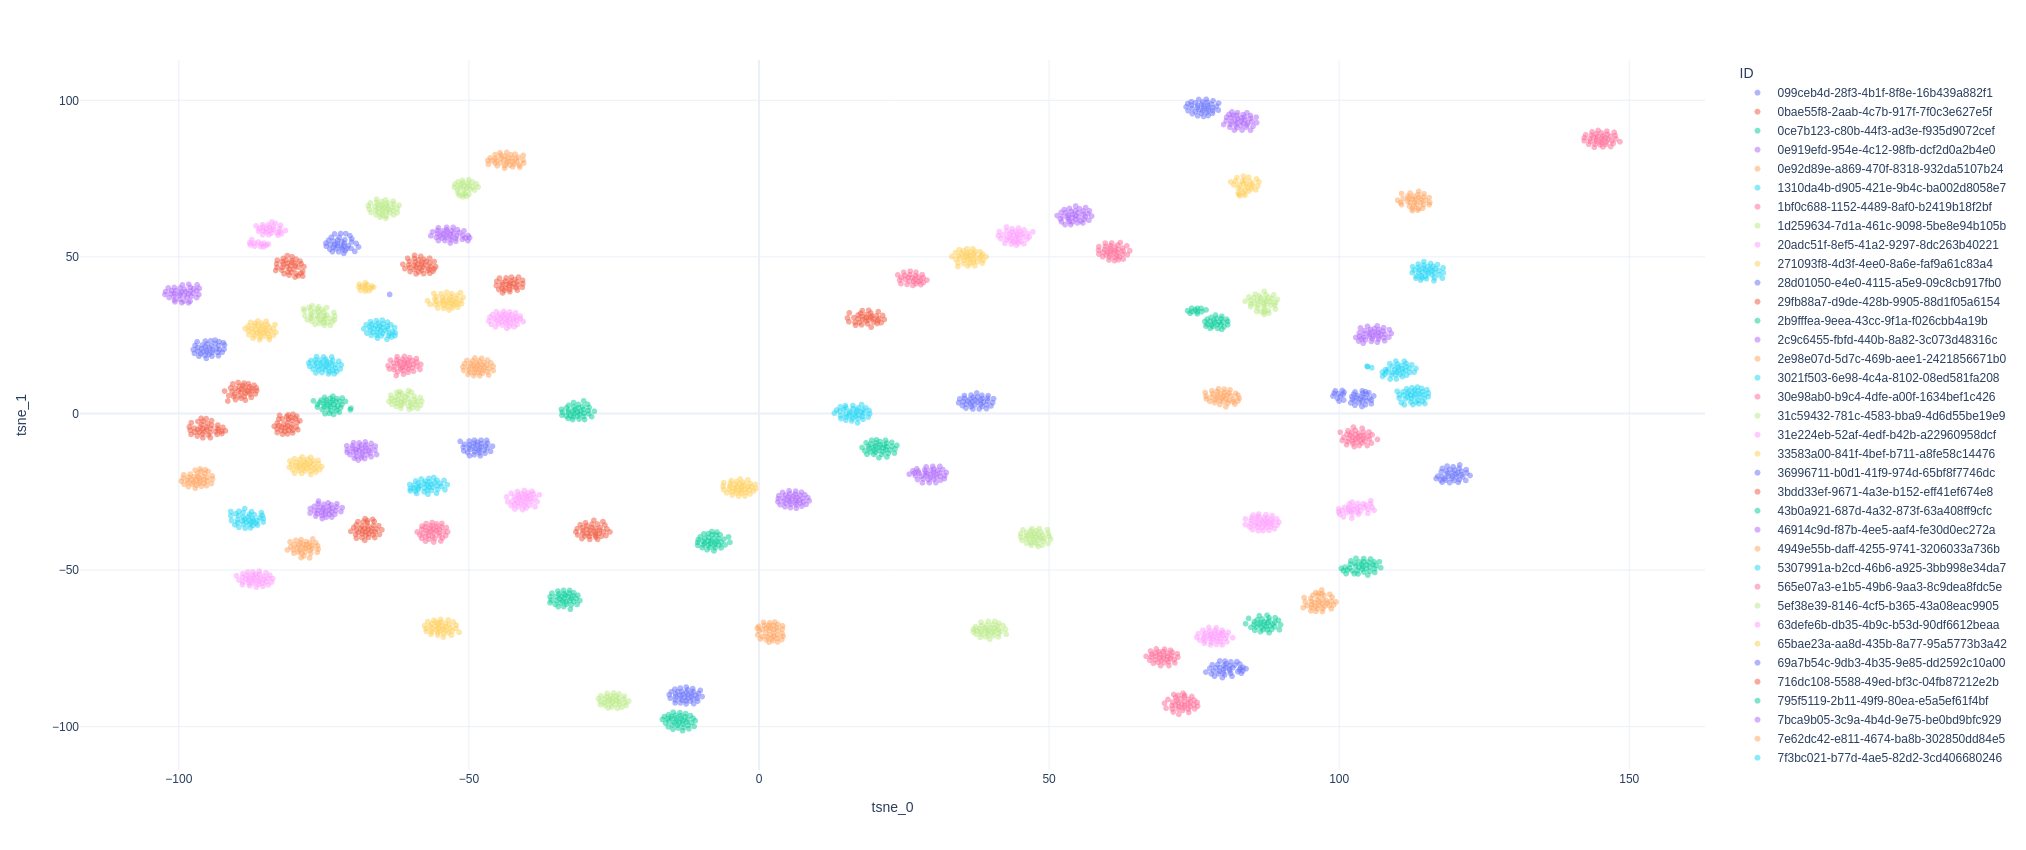

In [35]:
px.scatter(
    construct_tsne_df(tsne_result_fd),
    x="tsne_0",
    y="tsne_1",
    color="ID",
    hover_data=["timestamp", "pic_name", "wav_timestamp"],
    opacity=0.5,
    height=850,
    template="plotly_white",
)


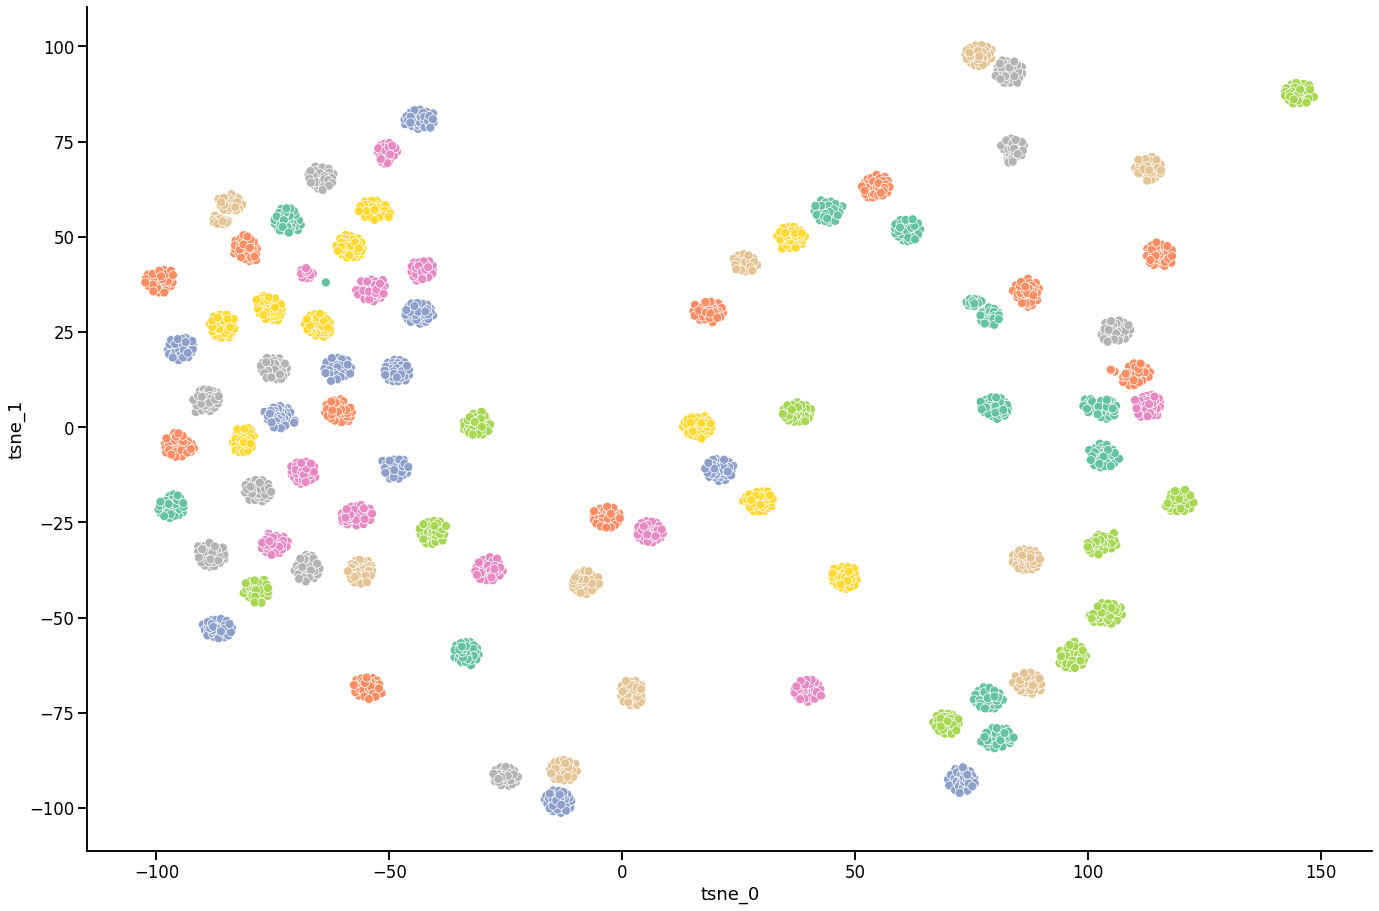

In [36]:
label_col = "ID"
sns.relplot(
    data=construct_tsne_df(tsne_result_fd),
    x="tsne_0",
    y="tsne_1",
    hue=label_col,
    height=13,
    kind="scatter",
    palette="Set2",
    aspect=1.5,
    legend=None,
)


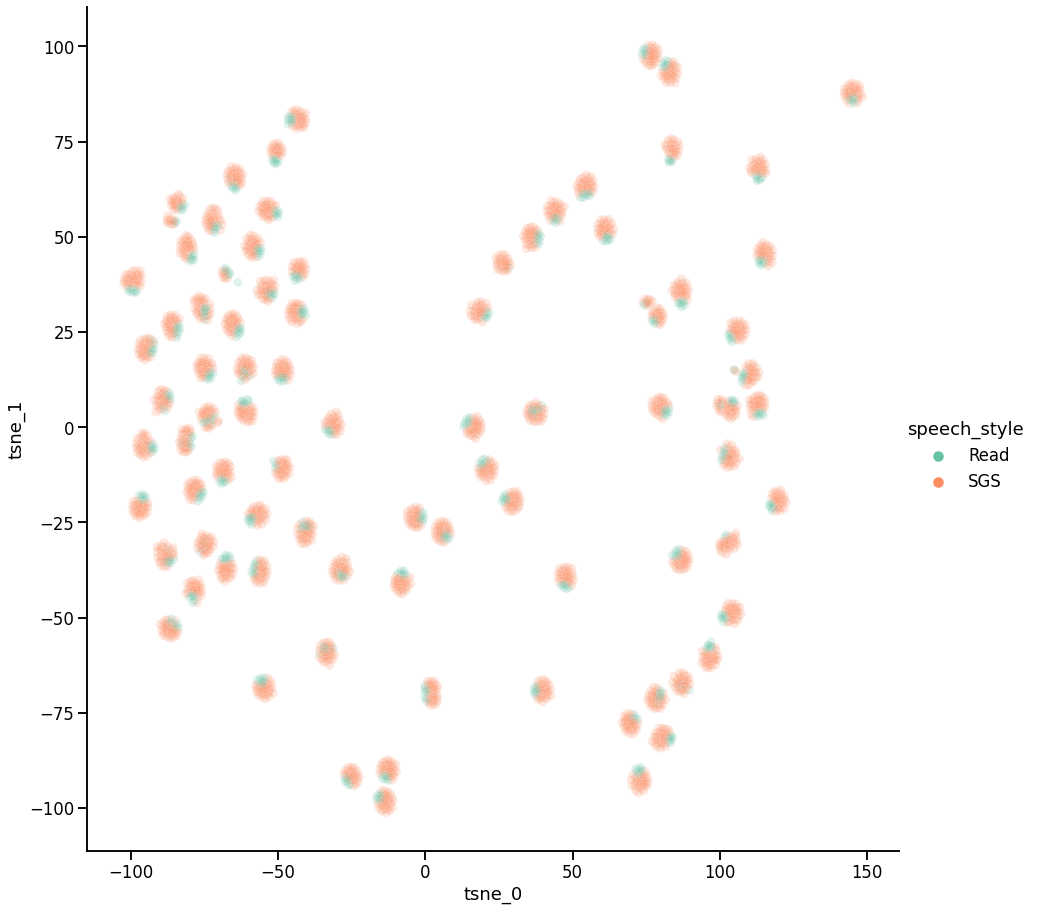

In [38]:
sns.relplot(
    data=construct_tsne_df(tsne_result_fd),
    x="tsne_0",
    y="tsne_1",
    hue="speech_style",
    height=13,
    kind="scatter",
    palette="Set2",
    aspect=1,
    alpha=0.2,
)


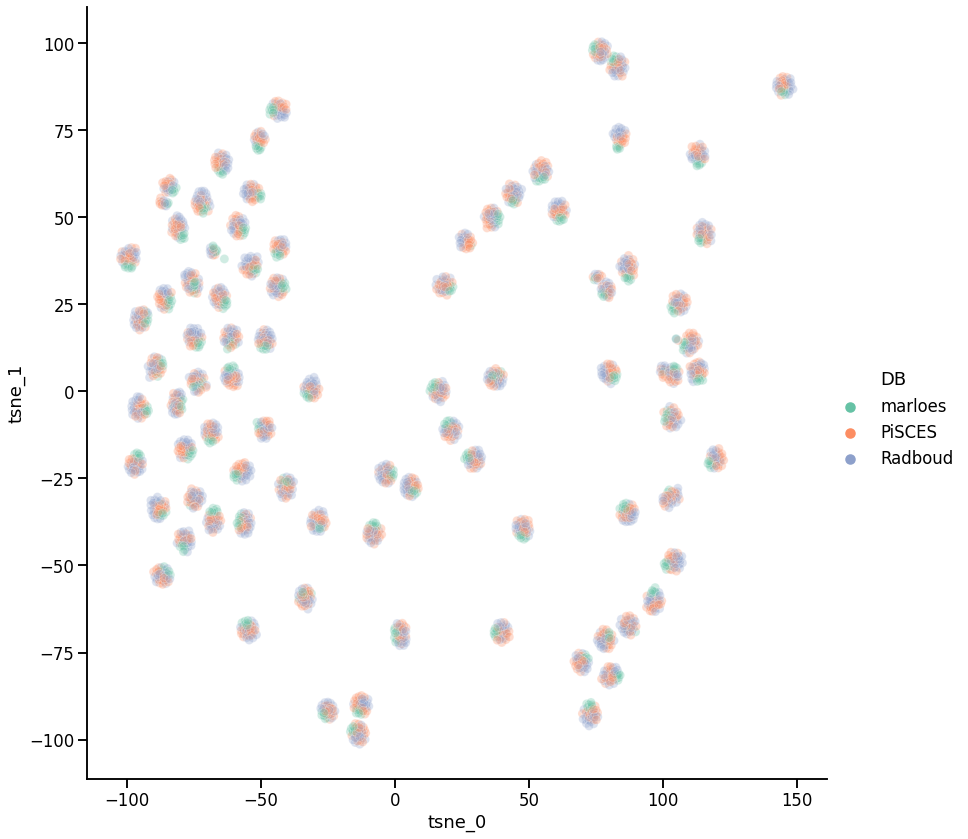

In [39]:
sns.relplot(
    data=construct_tsne_df(tsne_result_fd),
    x="tsne_0",
    y="tsne_1",
    hue="DB",
    height=12,
    kind="scatter",
    palette="Set2",
    aspect=1,
    alpha=0.3,
)


# Testing `speech-style` seperability 

In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    average_precision_score,
    f1_score,
    roc_auc_score,
    classification_report,
)
from sklearn.model_selection import (
    StratifiedGroupKFold,
    cross_val_score,
    cross_validate,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer
import matplotlib.pyplot as plt


In [41]:
df_emb_tot_fd_v["speech_style"].values


array(['Read', 'SGS', 'SGS', ..., 'SGS', 'SGS', 'Read'], dtype=object)

In [42]:
model = Pipeline(
    [
        ("scaling", PowerTransformer()),
        ("lr", LogisticRegression(C=0.1, solver="liblinear", max_iter=200)),
    ]
)

cvs = cross_val_score(
    estimator=model,
    X=df_emb_tot_fd_v.filter(like="emb_"),
    y=df_emb_tot_fd_v["speech_style"],
    scoring="balanced_accuracy",
    cv=StratifiedGroupKFold(n_splits=5),
    groups=df_emb_tot_fd_v["ID"],
)
print(cvs.round(3))
print(f"{cvs.mean().round(3)}±{cvs.std().round(3)}")


[0.824 0.896 0.852 0.865 0.877]
0.863±0.024


In [43]:
X = df_emb_tot_fd_v.filter(like="emb_").values
y = df_emb_tot_fd_v["speech_style"].values
groups = df_emb_tot_fd_v["ID"]


df_emb_tot_fd_v["speech_style_pred"] = None


              precision    recall  f1-score   support

        Read       0.88      0.67      0.76       106
         SGS       0.93      0.98      0.95       476

    accuracy                           0.92       582
   macro avg       0.90      0.82      0.86       582
weighted avg       0.92      0.92      0.92       582



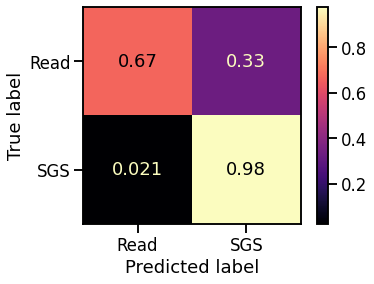

              precision    recall  f1-score   support

        Read       0.74      0.86      0.79       105
         SGS       0.97      0.94      0.95       496

    accuracy                           0.92       601
   macro avg       0.85      0.90      0.87       601
weighted avg       0.93      0.92      0.92       601



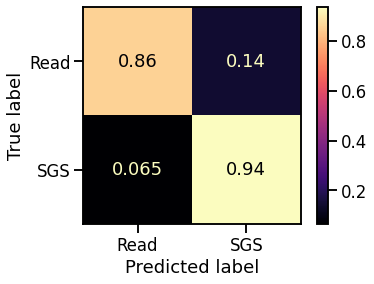

              precision    recall  f1-score   support

        Read       0.57      0.85      0.68       111
         SGS       0.96      0.86      0.91       497

    accuracy                           0.86       608
   macro avg       0.77      0.85      0.79       608
weighted avg       0.89      0.86      0.87       608



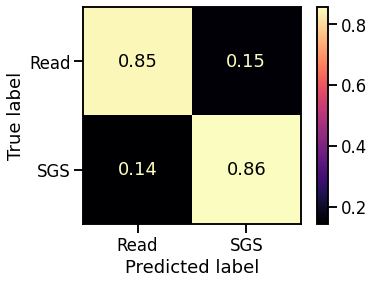

              precision    recall  f1-score   support

        Read       0.69      0.81      0.75       112
         SGS       0.96      0.92      0.94       494

    accuracy                           0.90       606
   macro avg       0.82      0.86      0.84       606
weighted avg       0.91      0.90      0.90       606



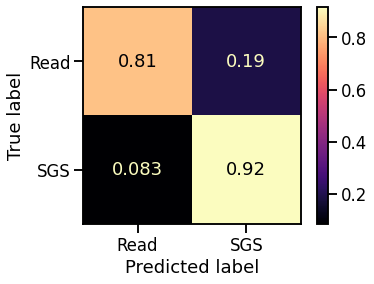

              precision    recall  f1-score   support

        Read       0.68      0.85      0.75       111
         SGS       0.96      0.91      0.93       481

    accuracy                           0.90       592
   macro avg       0.82      0.88      0.84       592
weighted avg       0.91      0.90      0.90       592



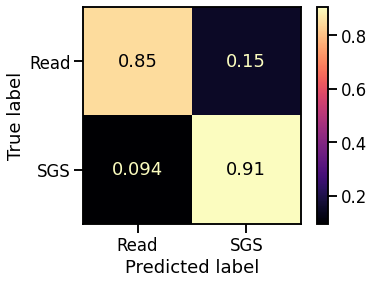

MF1 [0.857 0.872 0.794 0.841 0.843]
0.841±0.026
AUC [0.932 0.951 0.919 0.947 0.934]
0.937±0.011


In [62]:
mf1s = []
aps = []
aucs = []
kf = StratifiedGroupKFold(n_splits=5)
for train_idx, test_idx in kf.split(X, y=y, groups=groups):
    x_train_ = X[train_idx, :]
    x_test_cv_ = X[test_idx, :]
    model = model.fit(x_train_, y[train_idx])
    preds = model.predict(x_test_cv_)
    df_emb_tot_fd_v.iloc[
        test_idx, df_emb_tot_fd_v.columns.get_loc("speech_style_pred")
    ] = preds
    preds_proba = model.predict_proba(x_test_cv_)[:, 1]
    mf1s += [f1_score(y[test_idx], preds, average="macro")]
    print(classification_report(y[test_idx], preds))
    ConfusionMatrixDisplay.from_estimator(
        model, x_test_cv_, y[test_idx], normalize="true", cmap="magma"
    )
    plt.show()
    # aps += [average_precision_score(y[test_idx], preds_proba)]
    aucs += [roc_auc_score(y[test_idx], preds_proba)]

mf1s = np.array(mf1s)
print("MF1", mf1s.round(3))
print(f"{mf1s.mean().round(3)}±{mf1s.std().round(3)}")
aucs = np.array(aucs)
print("AUC", aucs.round(3))
print(f"{aucs.mean().round(3)}±{aucs.std().round(3)}")

In [45]:
df_emb_tot_fd_v["misprediction"] = (
    df_emb_tot_fd_v["speech_style"] != df_emb_tot_fd_v["speech_style_pred"]
)


In [46]:
df_emb_tot_fd_v.groupby("ID")["misprediction"].sum().sort_values(ascending=False)


ID
9223720f-1a2a-4811-84a1-a421646f63a0    24
1bf0c688-1152-4489-8af0-b2419b18f2bf    23
a8fda205-f95f-4b90-b2b1-7b1c59af2f45    13
b9b76603-d8c1-4ae7-88a0-5563221a13e5    12
fb807c80-22cc-4964-81a0-8c732f572004    12
                                        ..
8f42a931-7bd1-4536-bec3-a5f24da3c61f     0
94025116-4e19-4718-9e4e-c9f5af205b4c     0
9a725424-aafb-4d9b-8be7-acad80a46614     0
b4e53aa5-3bdc-4451-9cbf-20e94668f86c     0
992fb536-7504-4c58-adaf-bd6498d96dc7     0
Name: misprediction, Length: 84, dtype: int64

<AxesSubplot:>

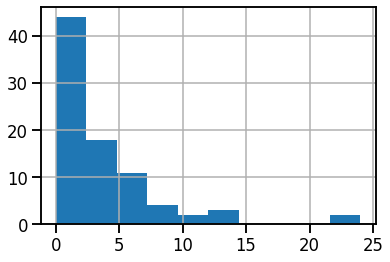

In [47]:
df_emb_tot_fd_v.groupby("ID")["misprediction"].sum().hist()


In [49]:
# df_emb_tot_fd_v[(df_emb_tot_fd_v.ID == "2b9fffea-9eea-43cc-9f1a-f026cbb4a19b")][
#     [
#         "timestamp",
#         "wav_timestamp",
#         "DB",
#         "pic_name",
#         "wav_duration_s",
#         "speech_style",
#         "speech_style_pred",
#         "misprediction",
#     ]
# ]


In [60]:
# df_emb_tot_fd_v[(df_emb_tot_fd_v.ID == "1bf0c688-1152-4489-8af0-b2419b18f2bf")][
#     [
#         "wav_timestamp",
#         "DB",
#         "pic_name",
#         "wav_duration_s",
#         "speech_style",
#         "speech_style_pred",
#         "misprediction",
#     ]
# ]


In [61]:
# df_emb_tot_fd_v[(df_emb_tot_fd_v.ID == "9223720f-1a2a-4811-84a1-a421646f63a0")][
#     [
#         "timestamp",
#         "wav_timestamp",
#         "DB",
#         "pic_name",
#         "wav_duration_s",
#         "speech_style",
#         "speech_style_pred",
#         "misprediction",
#     ]
# ]
